vary photon ID criteria {loose, medium, tight}, check yields

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join

########## backgrounds ##########
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbackgrounds_v2.json'))) # loose
bkgscales_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_scale_v2.json')))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/skimmed_control_data2018_v2.json')))
datadatasets = datadatasets_
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

# common plotting options
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

In [4]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        qsum_axis = hist.Bin('qsum', '$\Sigma q$', 5, -2, 3)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 30, 0, np.pi)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis),
            'ljqsum': hist.Hist("#counts", dataset_axis, qsum_axis, label_axis, channel_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            'eventcnt': hist.Hist("Counts", dataset_axis, count_axis, channel_axis),
            'ljcnt': hist.Hist("Counts", dataset_axis, count_axis, label_axis, channel_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_and.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets = leptonjets[leptonjets.isneutral]
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        leptonjets_ = dileptonjets[isControl]
        if leptonjets_.size==0: return output
        wgt = wgt[isControl]
        lj0 = lj0[isControl]
        lj1 = lj1[isControl]
        channel_ = channel_[isControl]
        
#         if dataset.startswith('QCD') and wgt[channel_==2].size>0:
#             run = df['run'][twoleptonjets][isControl&(channel_==2)]
#             lumi = df['lumi'][twoleptonjets][isControl&(channel_==2)]
#             event = df['event'][twoleptonjets][isControl&(channel_==2)]
#             for r, l, e in np.nditer([run, lumi, event]):
#                 print(f'{dataset} | {r}:{l}:{e} -- weight: {wgt}')
#             if dataset=='QCD_Pt-120to170':
#                 print(f'weight: {wgt}')
            
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt, channel=channel_)
        output['eventcnt'].fill(dataset=dataset, cnt=np.ones_like(wgt), weight=wgt, channel=channel_)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
        output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljqsum'].fill(dataset=dataset, qsum=leptonjets_.qsum.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljcnt'].fill(dataset=dataset, cnt=np.ones_like(ljwgt), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        
        output['ljpair'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 32/32 [00:04<00:00,  7.90items/s]
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:307: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f11ec631080>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [6]:
def makeplot_2mu2e(plotvar, title, overflow='over', logy=True):
    fig, (axes, raxes) = plt.subplots(2,3,figsize=(24,8), sharex=True,
                                      gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07, wspace=0.1)

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(1,2)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(1,2)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(1,2)).integrate('channel', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(1,2)).integrate('channel', slice(1,2)).sum('cat'),
                   ax=raxes[0],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(2,3)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[1],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(2,3)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[1],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(2,3)).integrate('channel', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(2,3)).integrate('channel', slice(1,2)).sum('cat'),
                   ax=raxes[1],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(3,4)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[2],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(3,4)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[2],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(3,4)).integrate('channel', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(3,4)).integrate('channel', slice(1,2)).sum('cat'),
                   ax=raxes[2],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')
    for ax in axes:
        ax.autoscale(axis='x', tight=True)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(None)
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    for rax in raxes:
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
        rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")


    axes[0].set_title(f'[2mu2e|control region] egamma-type leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[2mu2e|control region] pfmu-type leptonjets {title}', x=0.0, ha="left")
    axes[2].set_title(f'[2mu2e|control region] dsamu-type leptonjets {title}', x=0.0, ha="left")

def makeplot_4mu(plotvar, title, overflow='over', logy=True, xlim=None):
    fig, (axes, raxes) = plt.subplots(2,3,figsize=(24,8), sharex=True,
                                      gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07, wspace=0.1)

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(1,2)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[0],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(1,2)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[0],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(1,2)).integrate('channel', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(1,2)).integrate('channel', slice(2,3)).sum('cat'),
                   ax=raxes[0],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(2,3)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(2,3)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(2,3)).integrate('channel', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(2,3)).integrate('channel', slice(2,3)).sum('cat'),
                   ax=raxes[1],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(3,4)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[2],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(3,4)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[2],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(3,4)).integrate('channel', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(3,4)).integrate('channel', slice(2,3)).sum('cat'),
                   ax=raxes[2],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')
    for ax in axes:
        ax.autoscale(axis='x', tight=True)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(None)
        leg=ax.legend()
        if xlim:
            ax.set_xlim(*xlim)
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    for rax in raxes:
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
        rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")


    axes[0].set_title(f'[4mu|control region] egamma-type leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[4mu|control region] pfmu-type leptonjets {title}', x=0.0, ha="left")
    axes[2].set_title(f'[4mu|control region] dsamu-type leptonjets {title}', x=0.0, ha="left")

    
#######################
from collections import defaultdict
import pandas as pd

def printYield_2mu2e():
    # 2mu2e channel
    result = defaultdict(dict)
    for i, name in enumerate(['egamma', 'pfmu', 'dsamu'], start=1):
        histMC = output['ljcnt_cat'][notdata].integrate('label', slice(i,i+1)).integrate('channel', slice(1,2))
        histData = output['ljcnt_cat']['data'].integrate('label', slice(i,i+1)).integrate('channel', slice(1,2))
        for k, v in histMC.values().items():
            result[name][k[0]] = round(v[0], 2)
        for k, v in histData.values().items():
            result[name][k[0]] = round(v[0], 2)
    return pd.DataFrame(result)

def printYield_4mu():
    # 4mu channel
    result = defaultdict(dict)
    for i, name in enumerate(['egamma', 'pfmu', 'dsamu'], start=1):
        histMC = output['ljcnt_cat'][notdata].integrate('label', slice(i,i+1)).integrate('channel', slice(2,3))
        histData = output['ljcnt_cat']['data'].integrate('label', slice(i,i+1)).integrate('channel', slice(2,3))
        for k, v in histMC.values().items():
            result[name][k[0]] = round(v[0], 2)
        for k, v in histData.values().items():
            result[name][k[0]] = round(v[0], 2)
    return pd.DataFrame(result)

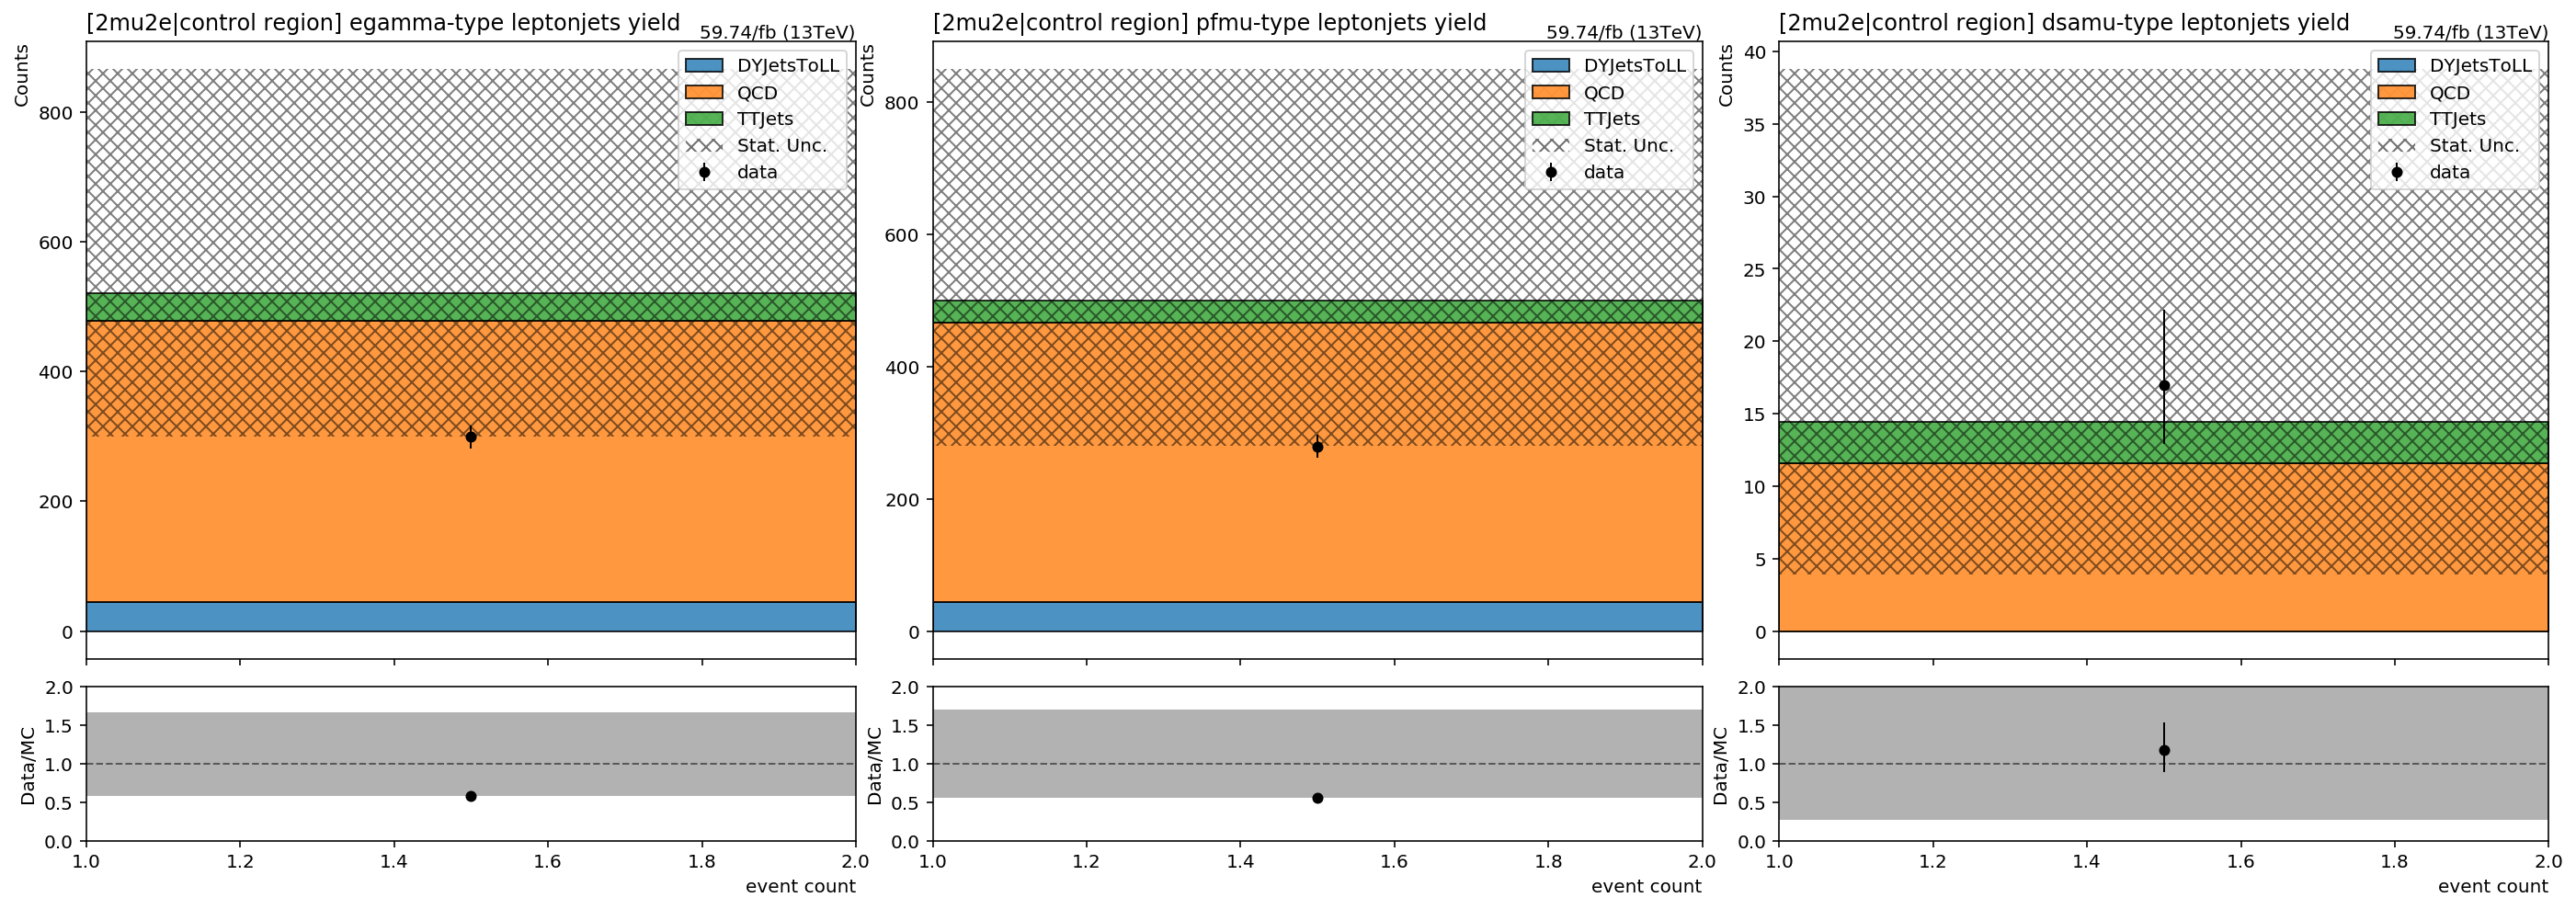

In [7]:
makeplot_2mu2e('ljcnt_cat', 'yield', logy=False, overflow='none', )

In [8]:
printYield_2mu2e()

,egamma,pfmu,dsamu
DYJetsToLL,44.36,44.36,0.00
QCD,433.40,421.81,11.59
TTJets,43.02,34.41,2.87
data,299.00,279.00,17.00


/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


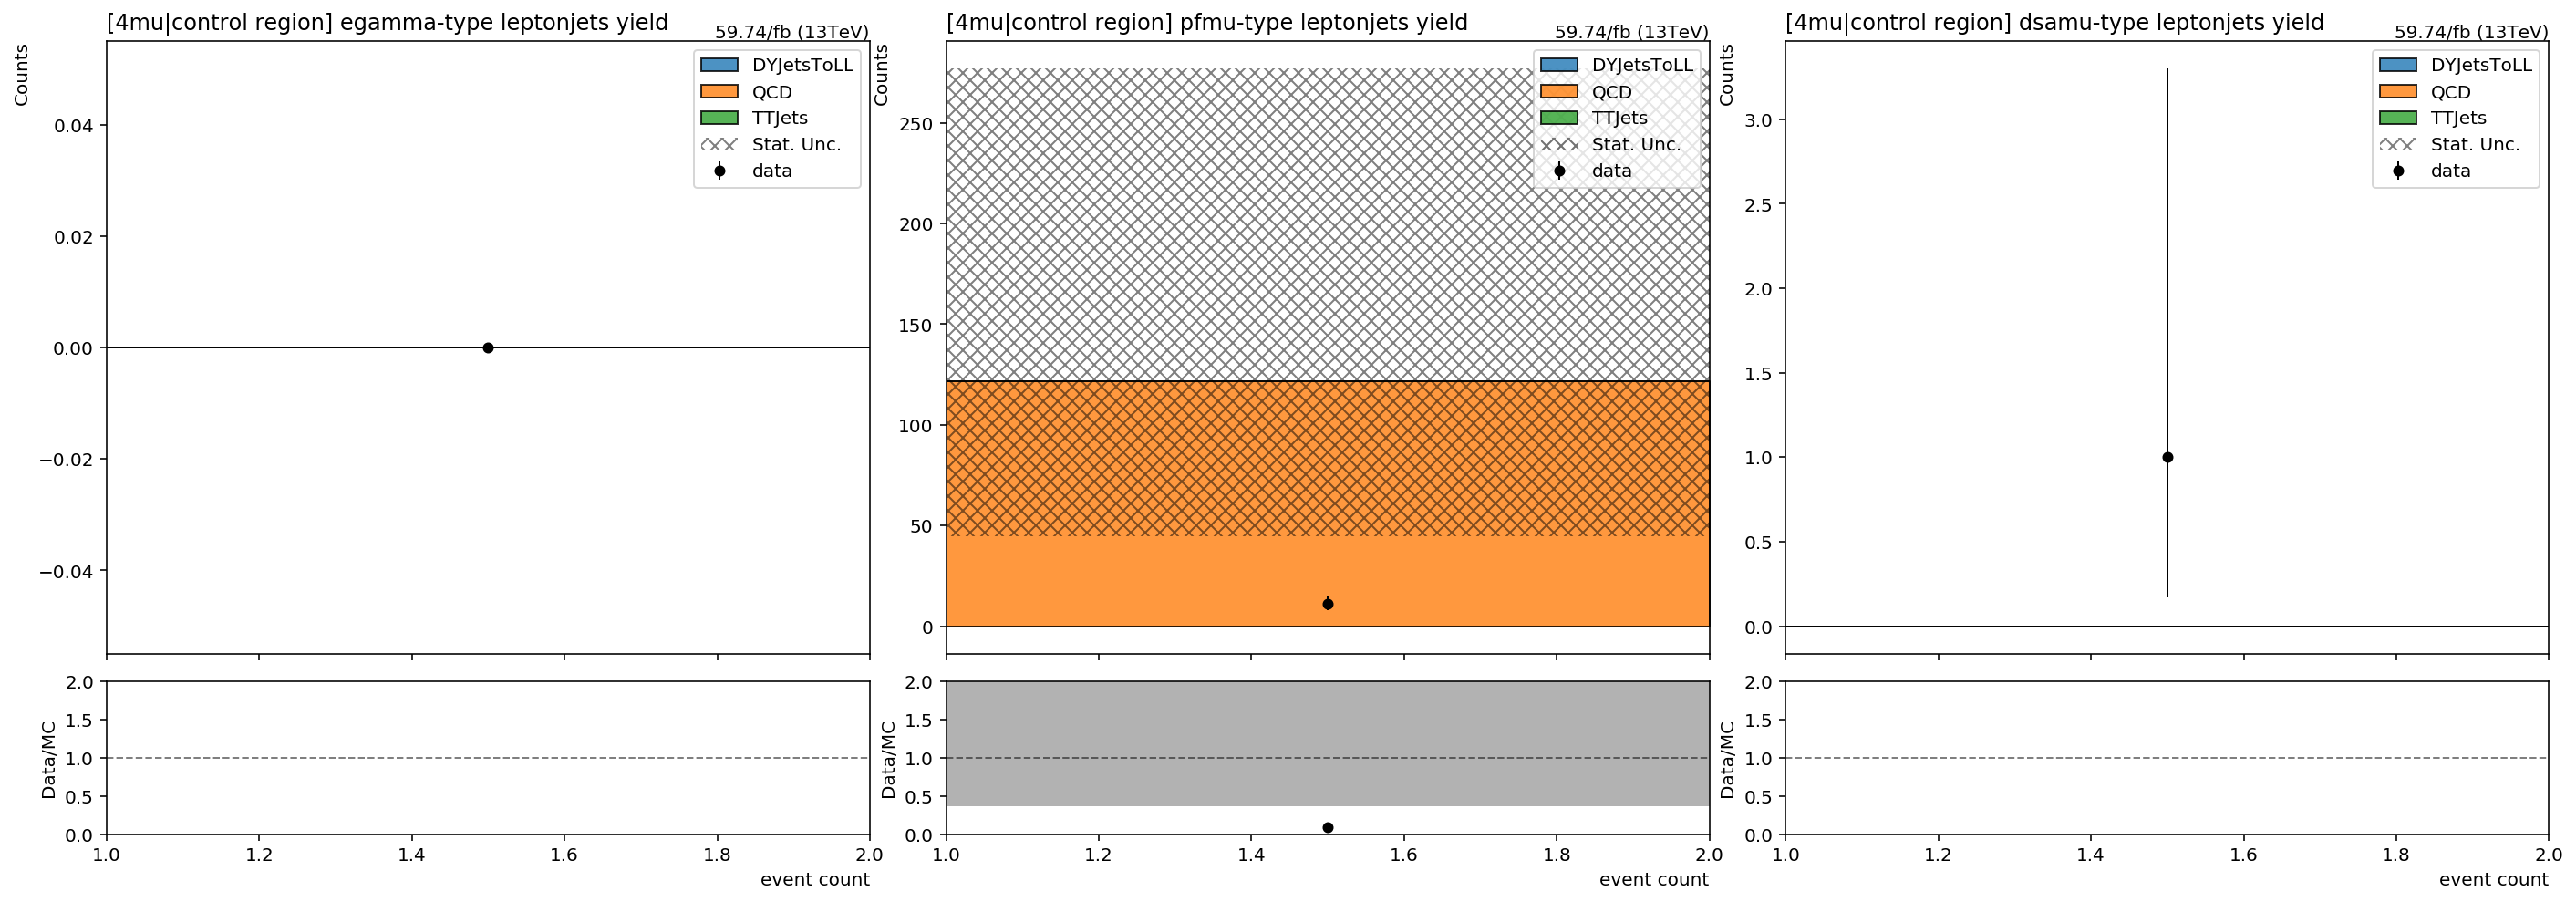

In [9]:
makeplot_4mu('ljcnt_cat', 'yield', logy=False, overflow='none', xlim=[1,2])

In [10]:
printYield_4mu()

,egamma,pfmu,dsamu
DYJetsToLL,0.0,0.00,0.0
QCD,0.0,121.85,0.0
TTJets,0.0,0.00,0.0
data,0.0,11.00,1.0


In [11]:
def makeplotByChannel(plotvar, title, overflow='over', logy=True, ylim=None):
    fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8), sharex=True,
                                      gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07, wspace=0.1)

    hist.plot1d(output[plotvar][notdata].integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('channel', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('channel', slice(1,2)).sum('cat'),
                   ax=raxes[0],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('channel', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('channel', slice(2,3)).sum('cat'),
                   ax=raxes[1],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    for ax in axes:
        ax.autoscale(axis='x', tight=True)
        if logy:
            ax.set_yscale('symlog')
            ax.autoscale(axis='y', tight=True)
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_xlabel(None)
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    for rax in raxes:
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
        rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")


    axes[0].set_title(f'[2mu2e|control region] leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[4mu|control region] leptonjets {title}', x=0.0, ha="left")
    
#######################
from collections import defaultdict
import pandas as pd

def printYieldByChannel():
    result = defaultdict(dict)
    for i, name in enumerate(['2mu2e', '4mu'], start=1):
        histMC = output['eventcnt_cat'][notdata].integrate('channel', slice(i,i+1))
        histData = output['eventcnt_cat']['data'].integrate('channel', slice(i,i+1))
        for k, v in histMC.values().items():
            result[name][k[0]] = round(v[0], 2)
        for k, v in histData.values().items():
            result[name][k[0]] = round(v[0], 2)
    return pd.DataFrame(result)


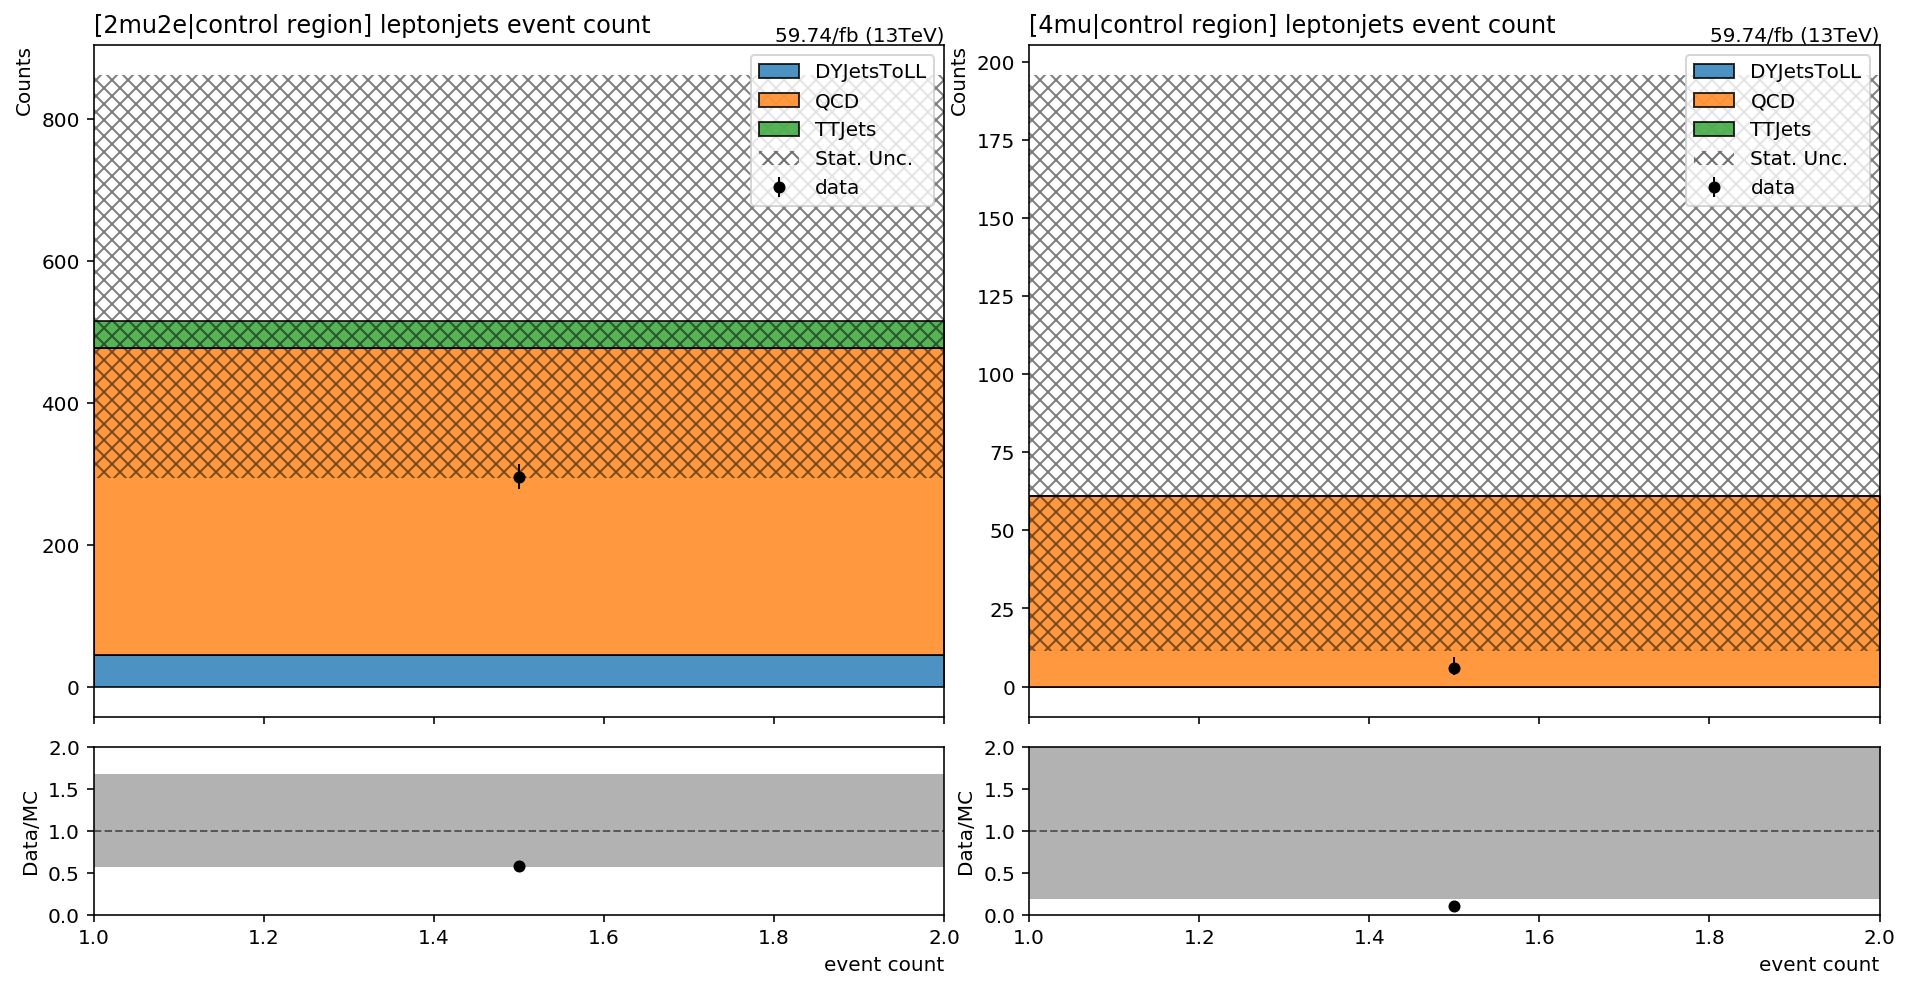

In [12]:
makeplotByChannel('eventcnt_cat', 'event count', overflow='none', logy=False)

In [13]:
printYieldByChannel()

,2mu2e,4mu
DYJetsToLL,44.36,0.00
QCD,433.40,60.93
TTJets,37.28,0.00
data,296.00,6.00


## photon - medium

In [16]:
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbkg_MediumPhoton.json'))) # medium
# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]
datasets.update(bkgdatasets)

In [18]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 32/32 [00:04<00:00,  7.93items/s]
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:307: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f11c98bdd68>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


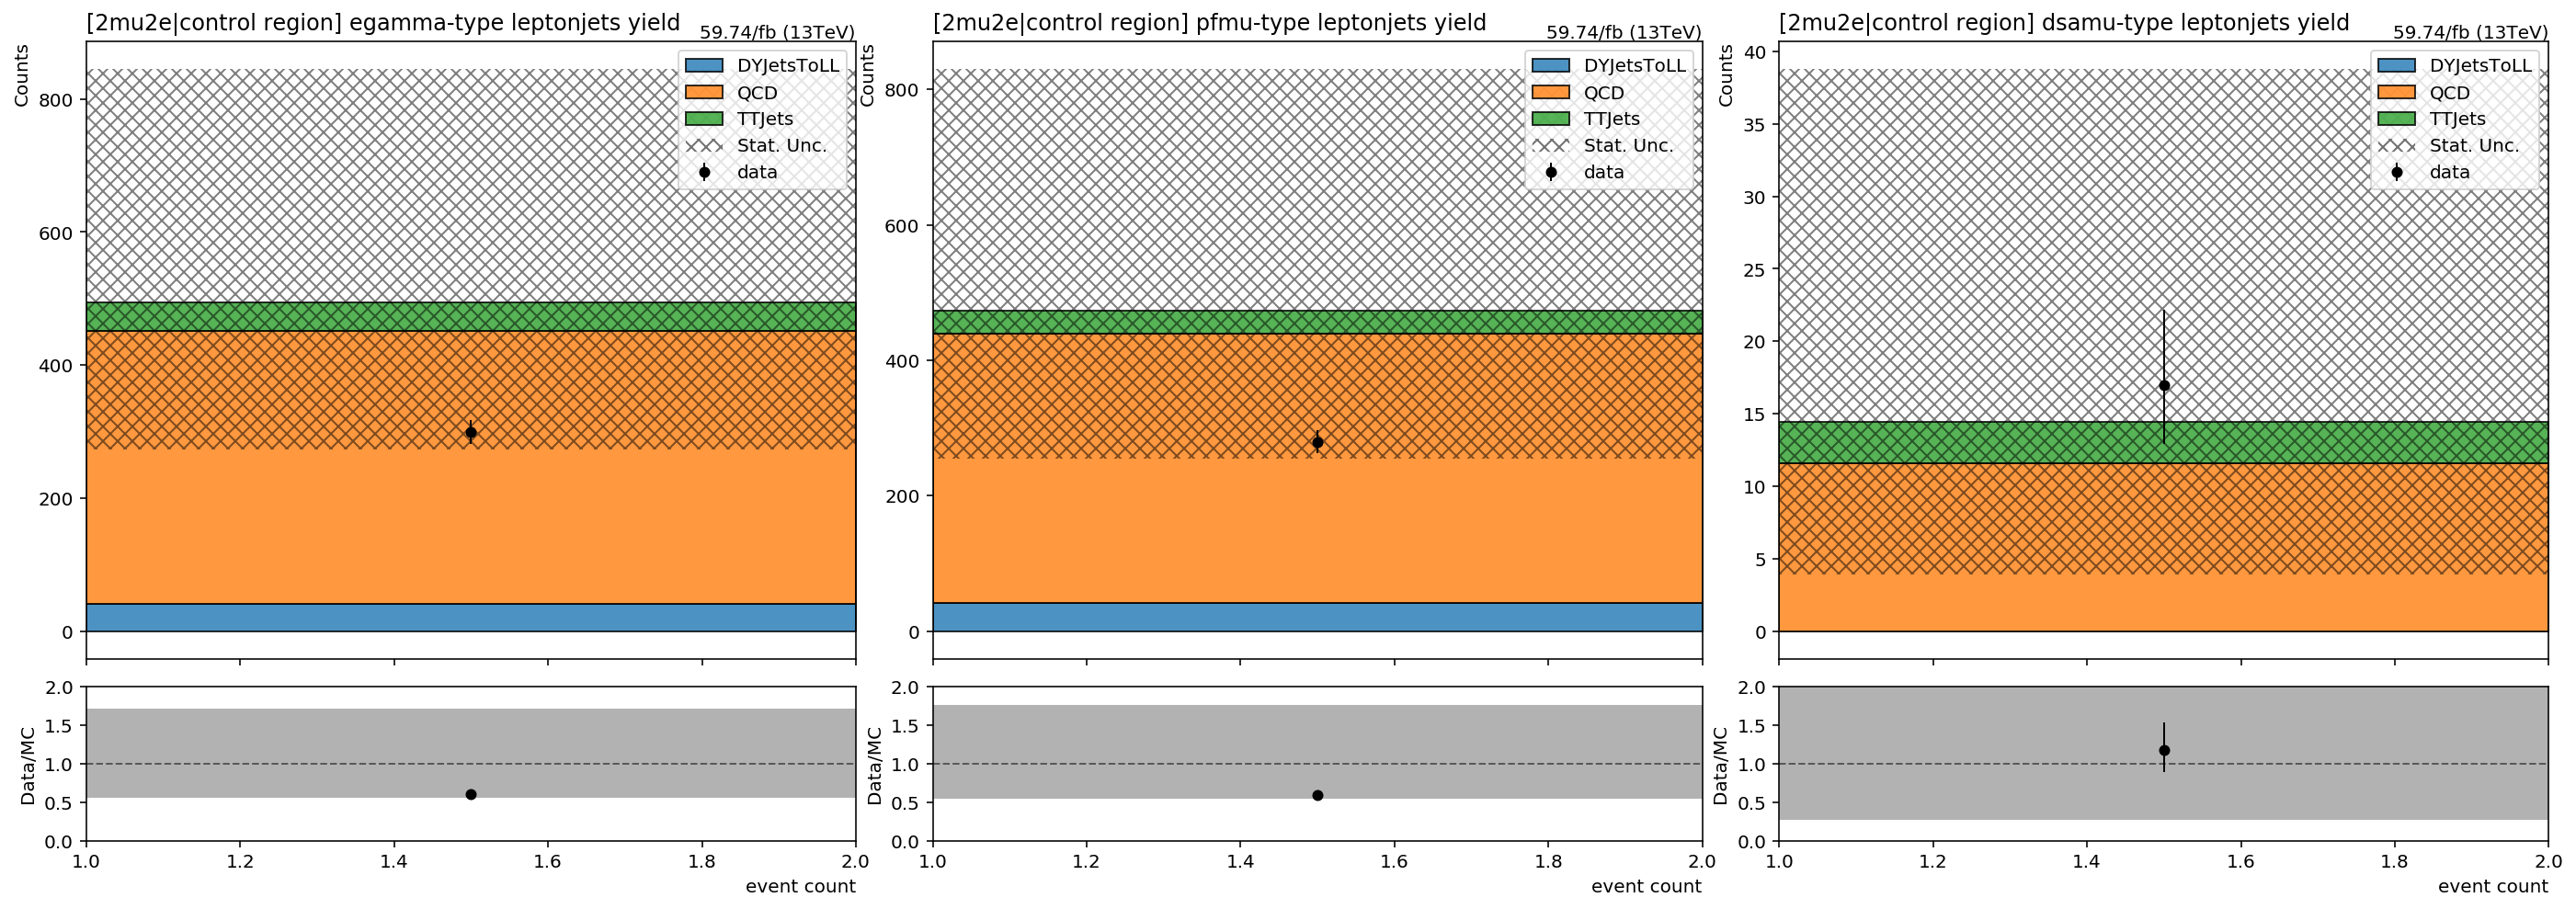

In [19]:
makeplot_2mu2e('ljcnt_cat', 'yield', logy=False, overflow='none', )

In [20]:
printYield_2mu2e()

,egamma,pfmu,dsamu
DYJetsToLL,41.18,41.18,0.00
QCD,409.78,398.19,11.59
TTJets,43.02,34.41,2.87
data,299.00,279.00,17.00


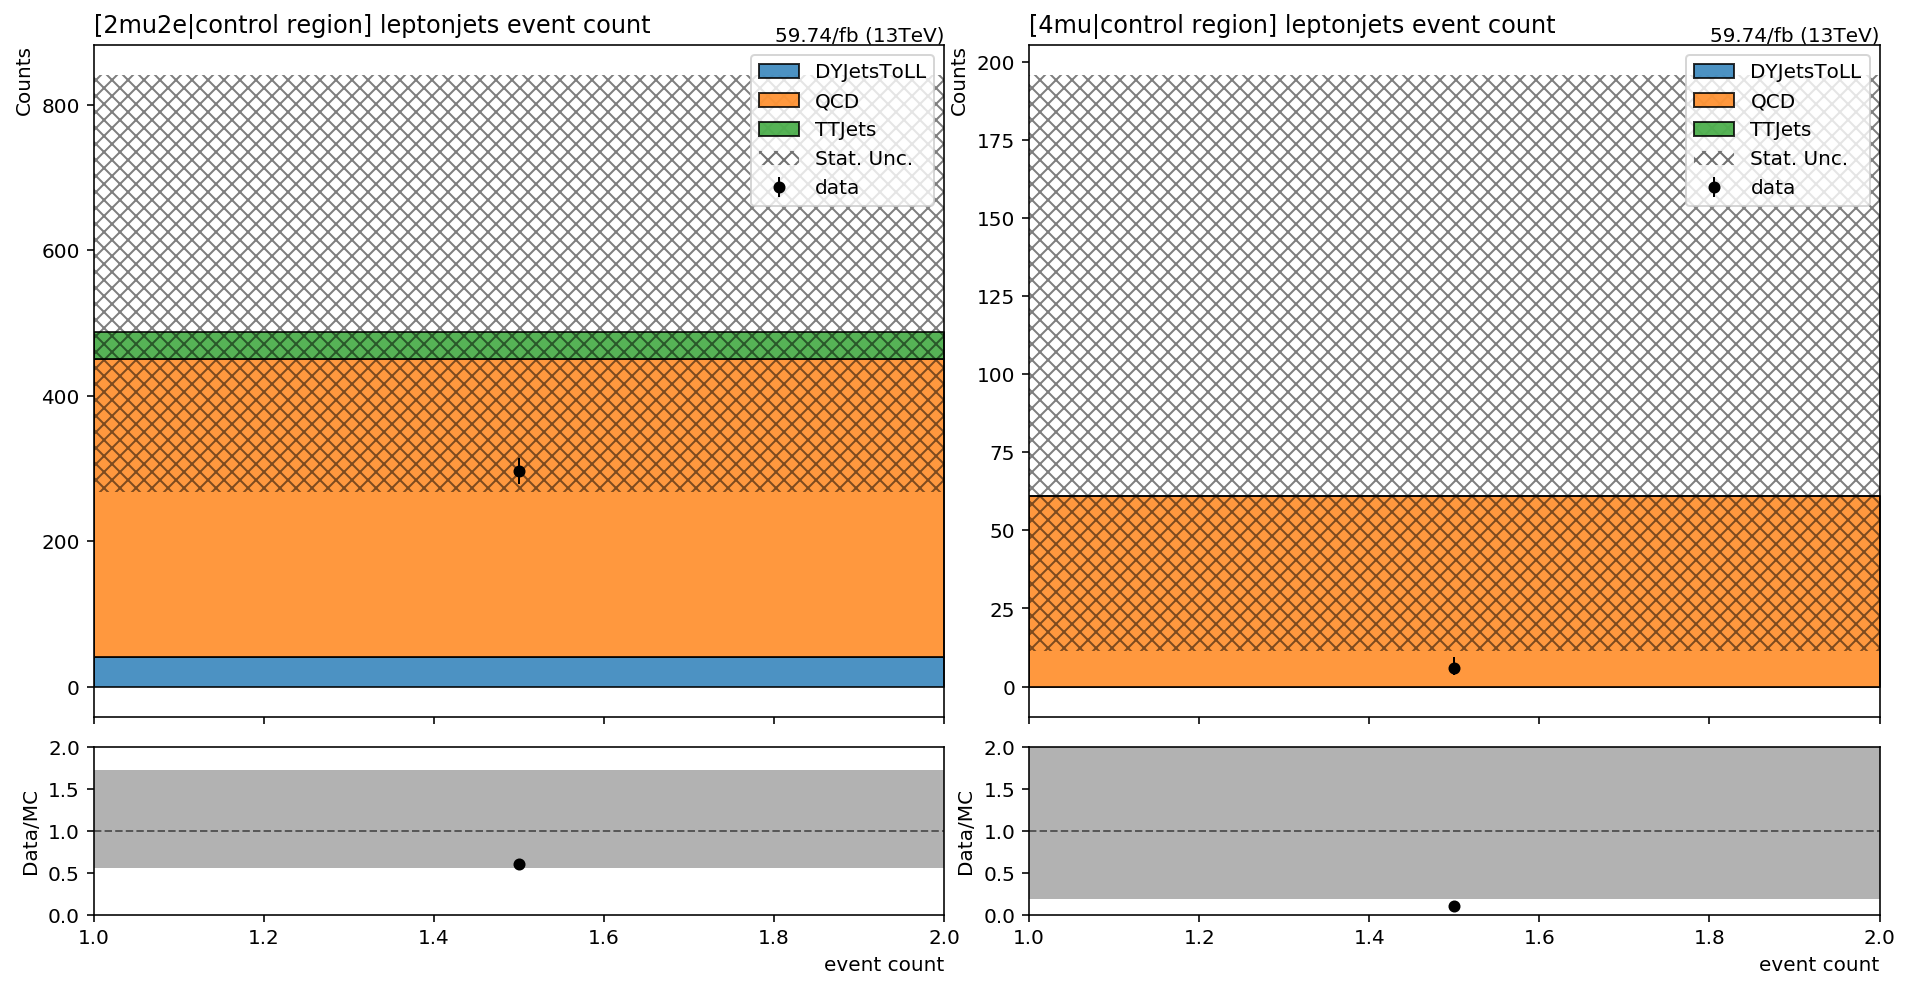

In [21]:
makeplotByChannel('eventcnt_cat', 'event count', overflow='none', logy=False)

In [22]:
printYieldByChannel()

,2mu2e,4mu
DYJetsToLL,41.18,0.00
QCD,409.78,60.93
TTJets,37.28,0.00
data,296.00,6.00


## photon - tight

In [23]:
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbkg_TightPhoton.json'))) # tight
# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]
datasets.update(bkgdatasets)

In [24]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 32/32 [00:03<00:00, 10.55items/s]
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:307: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f11c99918d0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


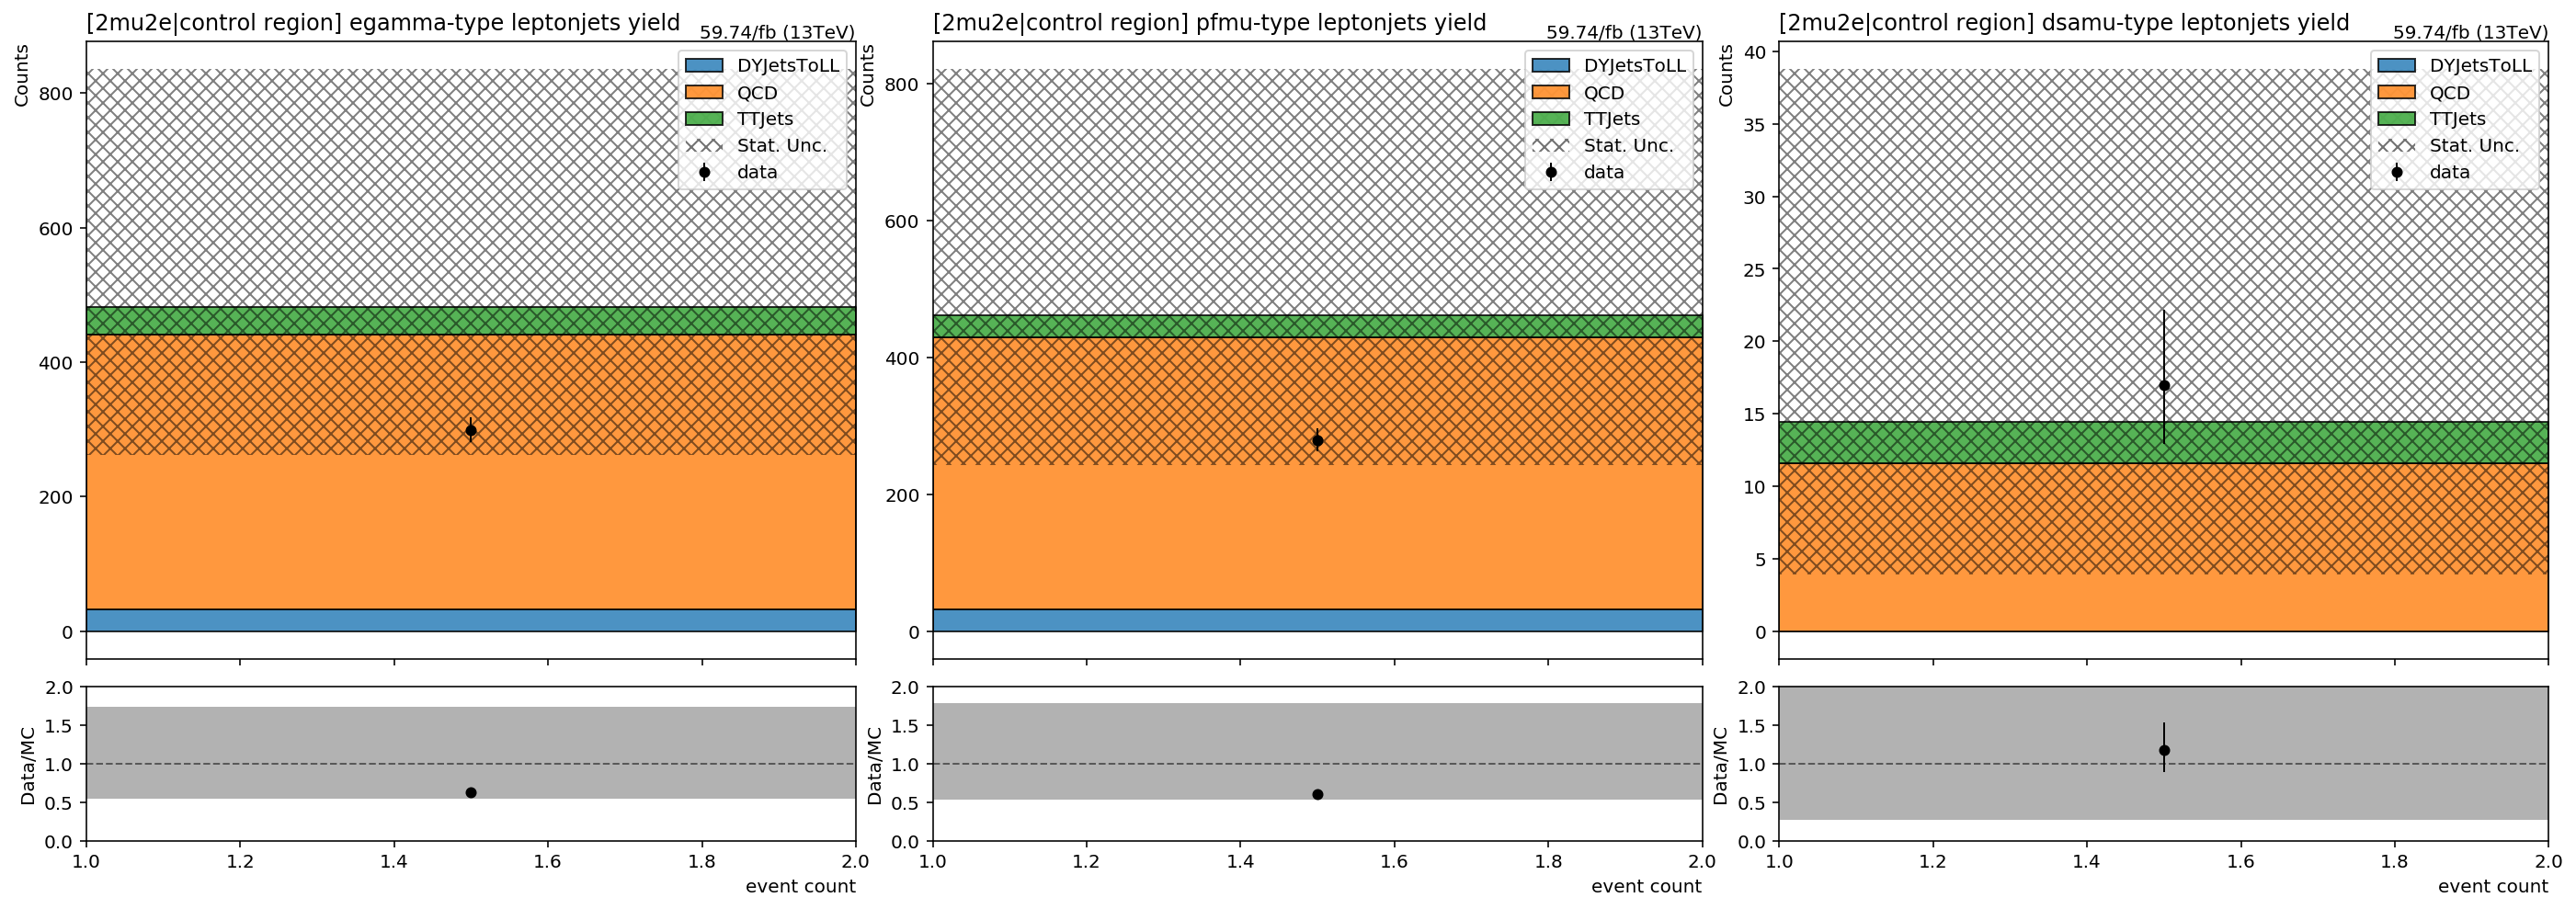

In [25]:
makeplot_2mu2e('ljcnt_cat', 'yield', logy=False, overflow='none', )

In [26]:
printYield_2mu2e()

,egamma,pfmu,dsamu
DYJetsToLL,31.67,31.67,0.00
QCD,409.58,397.99,11.59
TTJets,40.15,31.54,2.87
data,299.00,279.00,17.00


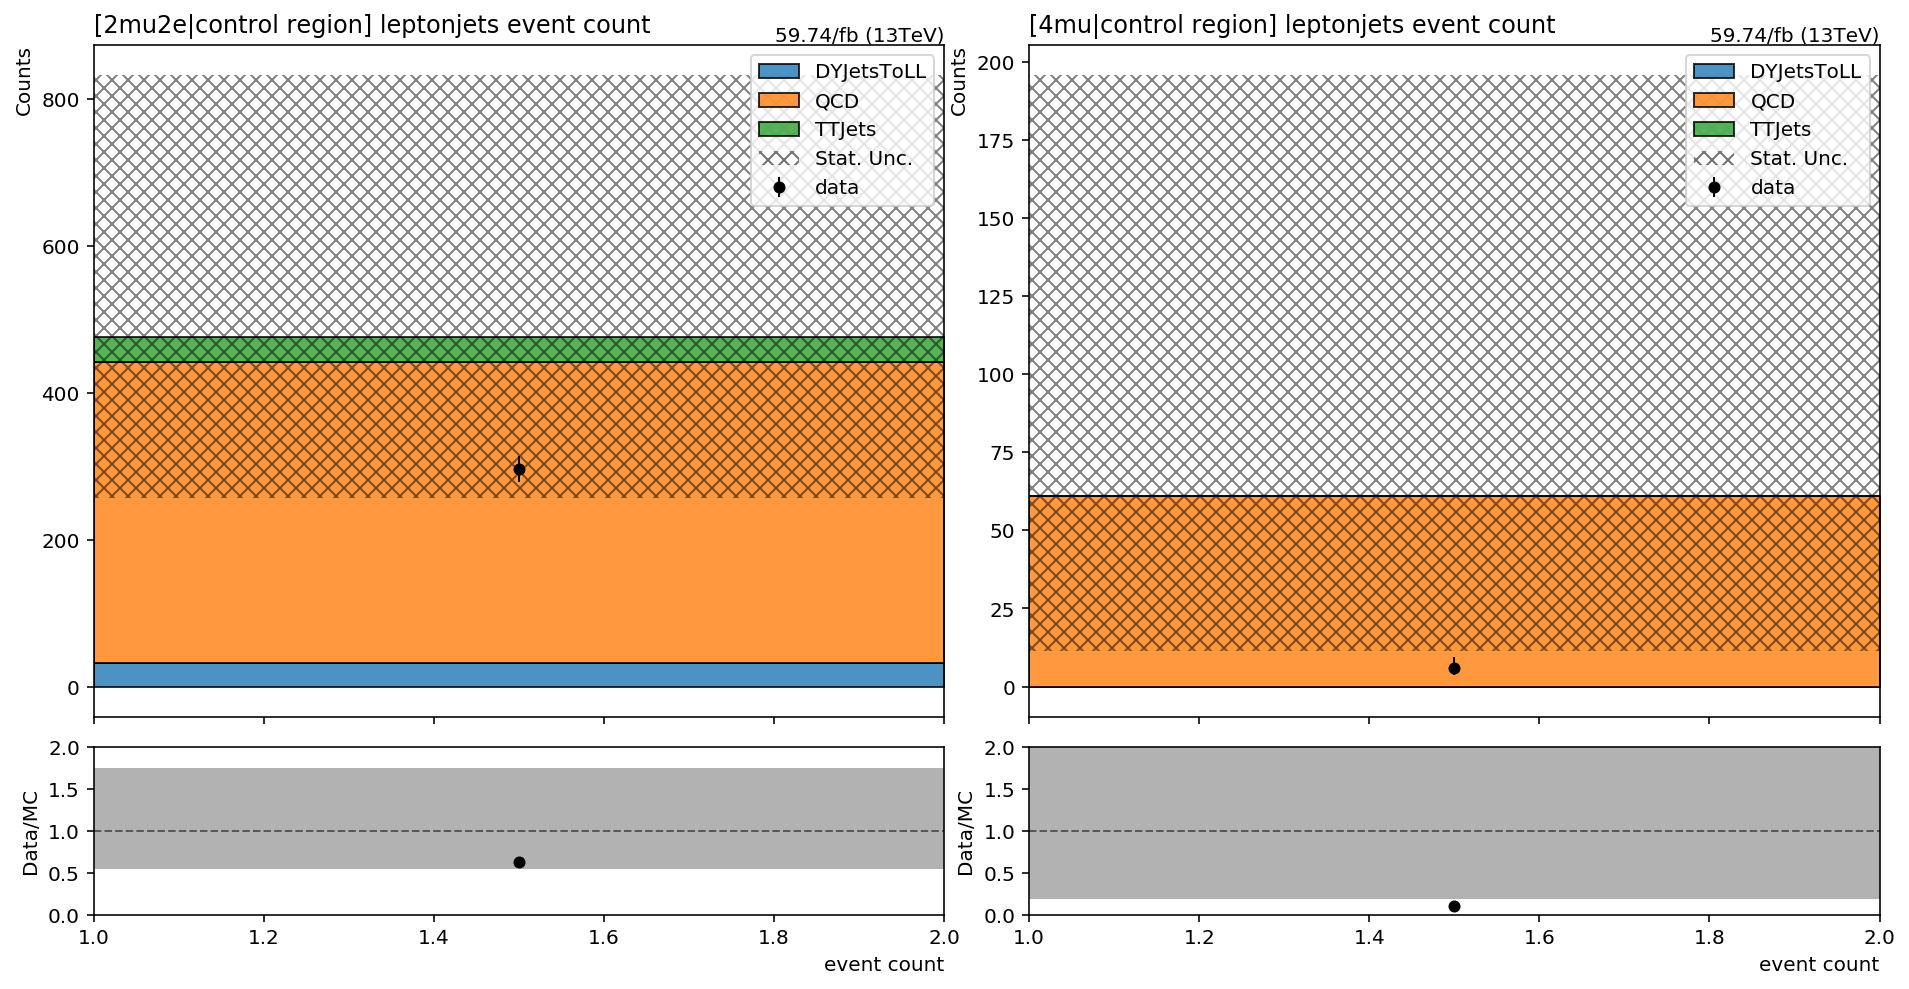

In [27]:
makeplotByChannel('eventcnt_cat', 'event count', overflow='none', logy=False)

In [28]:
printYieldByChannel()

,2mu2e,4mu
DYJetsToLL,31.67,0.00
QCD,409.58,60.93
TTJets,34.41,0.00
data,296.00,6.00
